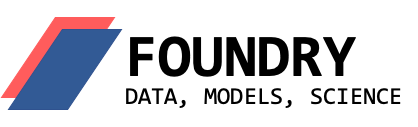

# Foundry Dendrite Segmentation Tutorial for Beginners
This introduction uses Foundry to:


1.   Load data from Foundry
2.   Build a predictuve U-Net model
3. Create augmented data to use with the model

This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.


In [ ]:
try:
  import google.colab
  no_local_server=True
  no_browser=True
  globus=False
except: # when not in google colab
  no_local_server=False
  no_browser=False
  globus=True

# Installing Foundry and Other Modules
First we'll need to install Foundry and [MDF](https://materialsdatafacility.org/), as well as a few other packages listed in requirements.txt. If you're using Google Colab, this code block will install these packages into the Colab environment. If you are running locally, it will install these modules onto your machine if you do not already have them.

In [ ]:
!pip install scikit-learn
!pip install numpy
!pip install foundry_ml
!pip install mdf_connect_client
!pip install scikit-image
!pip install tensorflow
!pip install keras-unet
!pip install opencv-python
!pip install pandas==1.2.2 tables==3.6.1

If running locally, just run the following line:

In [ ]:
!pip install -r requirements.txt

# Importing Packages
Now we can import Foundry, which will allow us to load the data. 

We'll be using [scikit-image](https://scikit-image.org/) for image processing; [Keras](https://keras.io/) and [TensorFlow](https://www.tensorflow.org/) to create our model; and [pandas](https://pandas.pydata.org/), [OpenCV](https://pypi.org/project/opencv-python/), and [NumPy ](https://numpy.org/)to work with our data.

In [ ]:
from foundry import Foundry
from skimage.io import imshow, imread
from keras_unet.models import custom_unet
import matplotlib.pyplot as plt
from keras_unet.utils import plot_imgs
import cv2
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import get_augmented

# Instantiating Foundry
To instantiate Foundry, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.


In [ ]:
f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)

# Loading the Data
Now we can use our instance of Foundry to load the data using `f.load()`. Once the data is loaded and accessible, we load the data into the client using `f.load_data()`.

In [ ]:
f.load("foundry_stan_segmentation_v1.1", globus=globus)

Foundry(dc={'creators': [{'affiliations': ['Northwestern University'], 'creatorName': 'Stan, Tiberiu', 'familyName': 'Stan', 'givenName': 'Tiberiu'}, {'affiliations': ['Northwestern University'], 'creatorName': 'Thompson, Zach', 'familyName': 'Thompson', 'givenName': 'Zach'}, {'affiliations': ['Northwestern University'], 'creatorName': 'Voorhees, Peter', 'familyName': 'Voorhees', 'givenName': 'Peter'}], 'dates': [{'date': '2021-07-07', 'dateType': 'Accepted'}], 'identifier': {'identifier': '10.23677/97vx-s71w', 'identifierType': 'DOI'}, 'publicationYear': 2021, 'publisher': 'Materials Data Facility', 'resourceType': {'resourceType': 'Dataset', 'resourceTypeGeneral': 'Dataset'}, 'subjects': [{'subject': 'machine learning'}, {'subject': 'foundry'}, {'subject': 'segmentation'}, {'subject': 'metals and alloys'}], 'titles': [{'title': 'Semantic Segmentation of Dendrites via Machine Learning - Dev'}]}, mdf={'ingest_date': '2021-07-07T00:58:35.552212Z', 'organizations': ['Foundry'], 'resource_type': 'dataset', 'scroll_id': 0, 'source_id': '_test_foundry_stan_segmentation_v1.1', 'source_name': '_test_foundry_stan_segmentation', 'version': 1}, dataset=FoundryDataset(keys=[FoundryKey(key=['train/input'], type='input', filter='', units='', description='input, unlabeled images', classes=None), FoundryKey(key=['train/output'], type='target', filter='', units='', description='target, labeled images', classes=None)], splits=[FoundrySplit(type='train', path='foundry.hdf5', label='train')], type=<FoundryDatasetType.hdf5: 'hdf5'>, short_name='segmentation', dataframe=None), config=FoundryConfig(dataframe_file='foundry_dataframe.json', data_file='foundry.hdf5', metadata_file='foundry_metadata.json', destination_endpoint=None, local=False, metadata_key='foundry', organization='foundry', local_cache_dir='./data'), dlhub_client=<dlhub_sdk.client.DLHubClient object at 0x7fa5788c2bb0>, forge_client=<mdf_forge.forge.Forge object at 0x7fa5b92349a0>, connect_client=<mdf_connect_client.mdfcc.MDFConnectClient object at 0x7fa5788c2b80>, xtract_tokens={'auth_token': 'AgwJBgv5q8yv8logGVxnBOQgyzkz40KYqkvNE2OOgBB2BYDKExilCNqVlX9G4Q0xQG41Qy2v2WDmPes27OE7DHoq2n', 'transfer_token': 'Agn2Dgngge62YYK6mzMzzKW8rMYMgD3k59n0g044p8KM6VlW5aH9CP8vle5vdJg7l1bWk9zkrNe93Vf0GwOG2TyNmq', 'funcx_token': 'Ag5N2BavMxMqDK0jldGnrWnjkpJr0xjnBvXn2Va7rlJ6pnKBeetnCw13xKJvwkBKN8zxljN3jGzMWYhKMaEMKU7J82'})

In [ ]:
res = f.load_data()
X,y = res['train']
X,y = X[0], y[0]


# Visualizing the Data

Now that we've loaded the data, let's take a look!

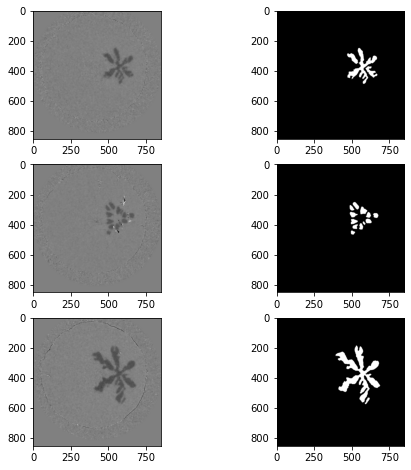

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(8,8))
for i in range(3):
    axs[i][0].imshow(X[i])
    axs[i][1].imshow(y[i])

# Building a Model
## Resize to Match UNet
UNet requires images to be of a size multiple of 32, so we'll resize them here.

In [ ]:
new_size = 32*10 # U-Net requires a multiple of 32

X_r = np.array([cv2.resize(img, dsize=(new_size, new_size)) 
     for img in X])
y_r = np.array([cv2.resize(mask, dsize=(new_size, new_size)) 
     for mask in y])

In [ ]:
y_r.shape

(30, 320, 320, 3)

## Create UNet Model

In [ ]:
input_shape = (new_size,new_size,3)

model = custom_unet(input_shape)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 320, 320, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Preview the Segmentation Task

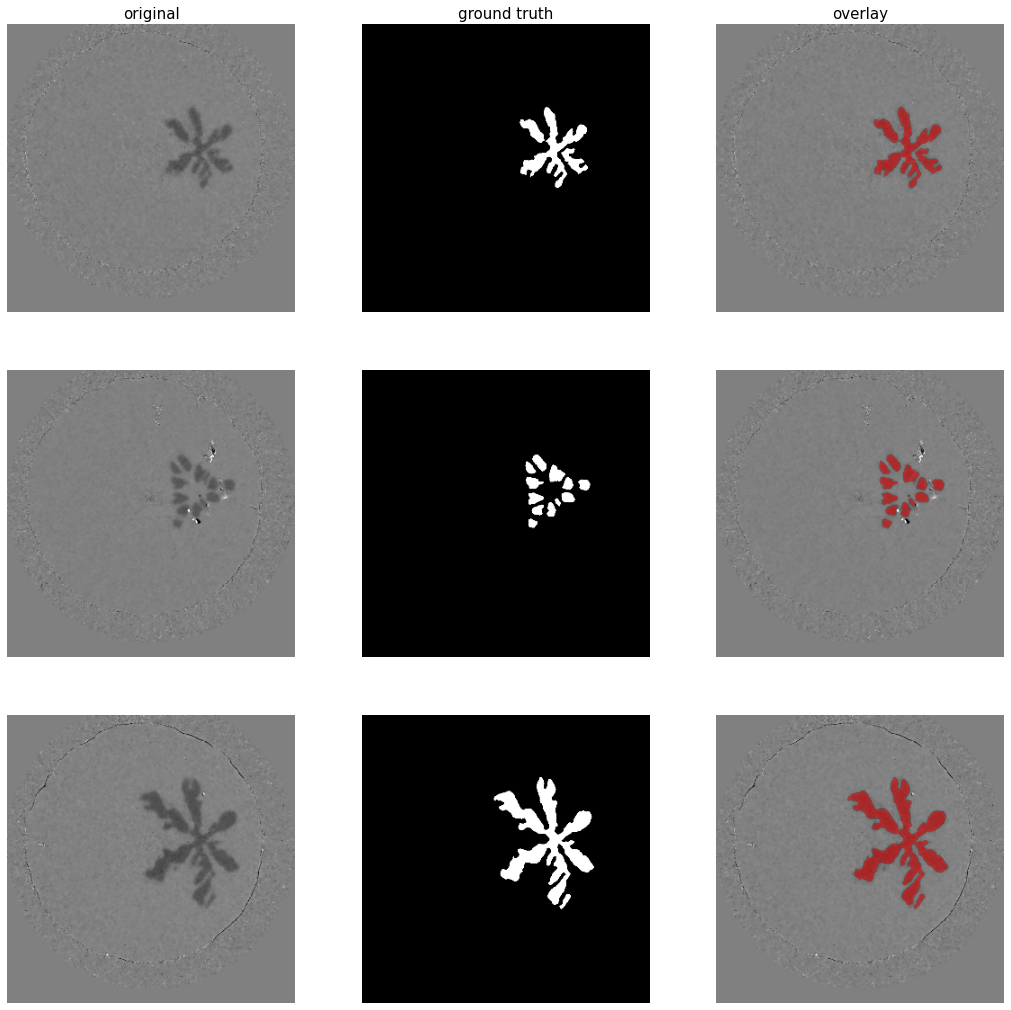

In [ ]:
plot_imgs(org_imgs=X_r, mask_imgs=y_r[:,:,:,0], nm_img_to_plot=3, figsize=6)


# Create a Generator with Augmented Images

In [ ]:
X_r.shape

(30, 320, 320, 3)

In [ ]:
y_r.shape

(30, 320, 320, 3)

In [ ]:
n_images = 30
y_c = y_r[:,:,:,0]

train_gen = get_augmented(
    X_r, np.reshape(y_c, (n_images, new_size, new_size, 1)), batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

# Preview Augmented Images

(2, 320, 320, 3) (2, 320, 320, 1)


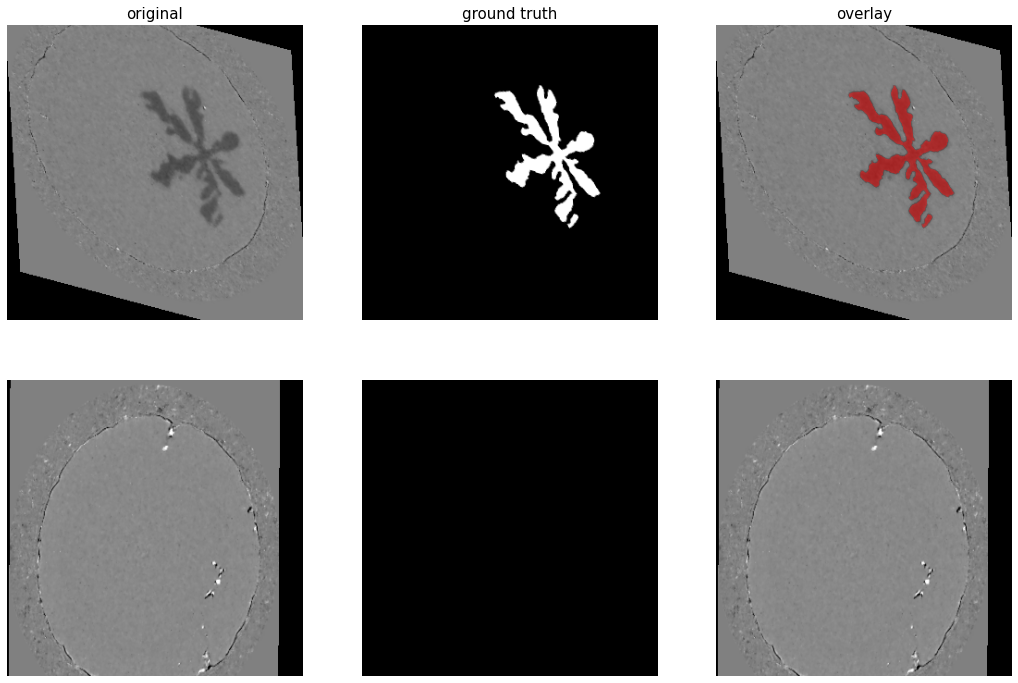

In [ ]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,0], nm_img_to_plot=2, figsize=6)

# Compile Model

In [ ]:
model.compile(
    optimizer="adam", 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Fit Model

In [ ]:
history = model.fit(
train_gen,
    steps_per_epoch=200,
    epochs=10
)

Epoch 1/10
 16/200 [=>............................] - ETA: 2:12 - loss: 0.7260 - mean_io_u: 0.4798

KeyboardInterrupt: 

In [ ]:
model.save(f"./{new_size}x{new_size}-model.h5") 

In [ ]:
model = tf.keras.models.load_model('./model_checkpoint.h5')

# Run Predict on Images

In [ ]:
y_pred = model.predict(X_r)

# Check Performance Visually

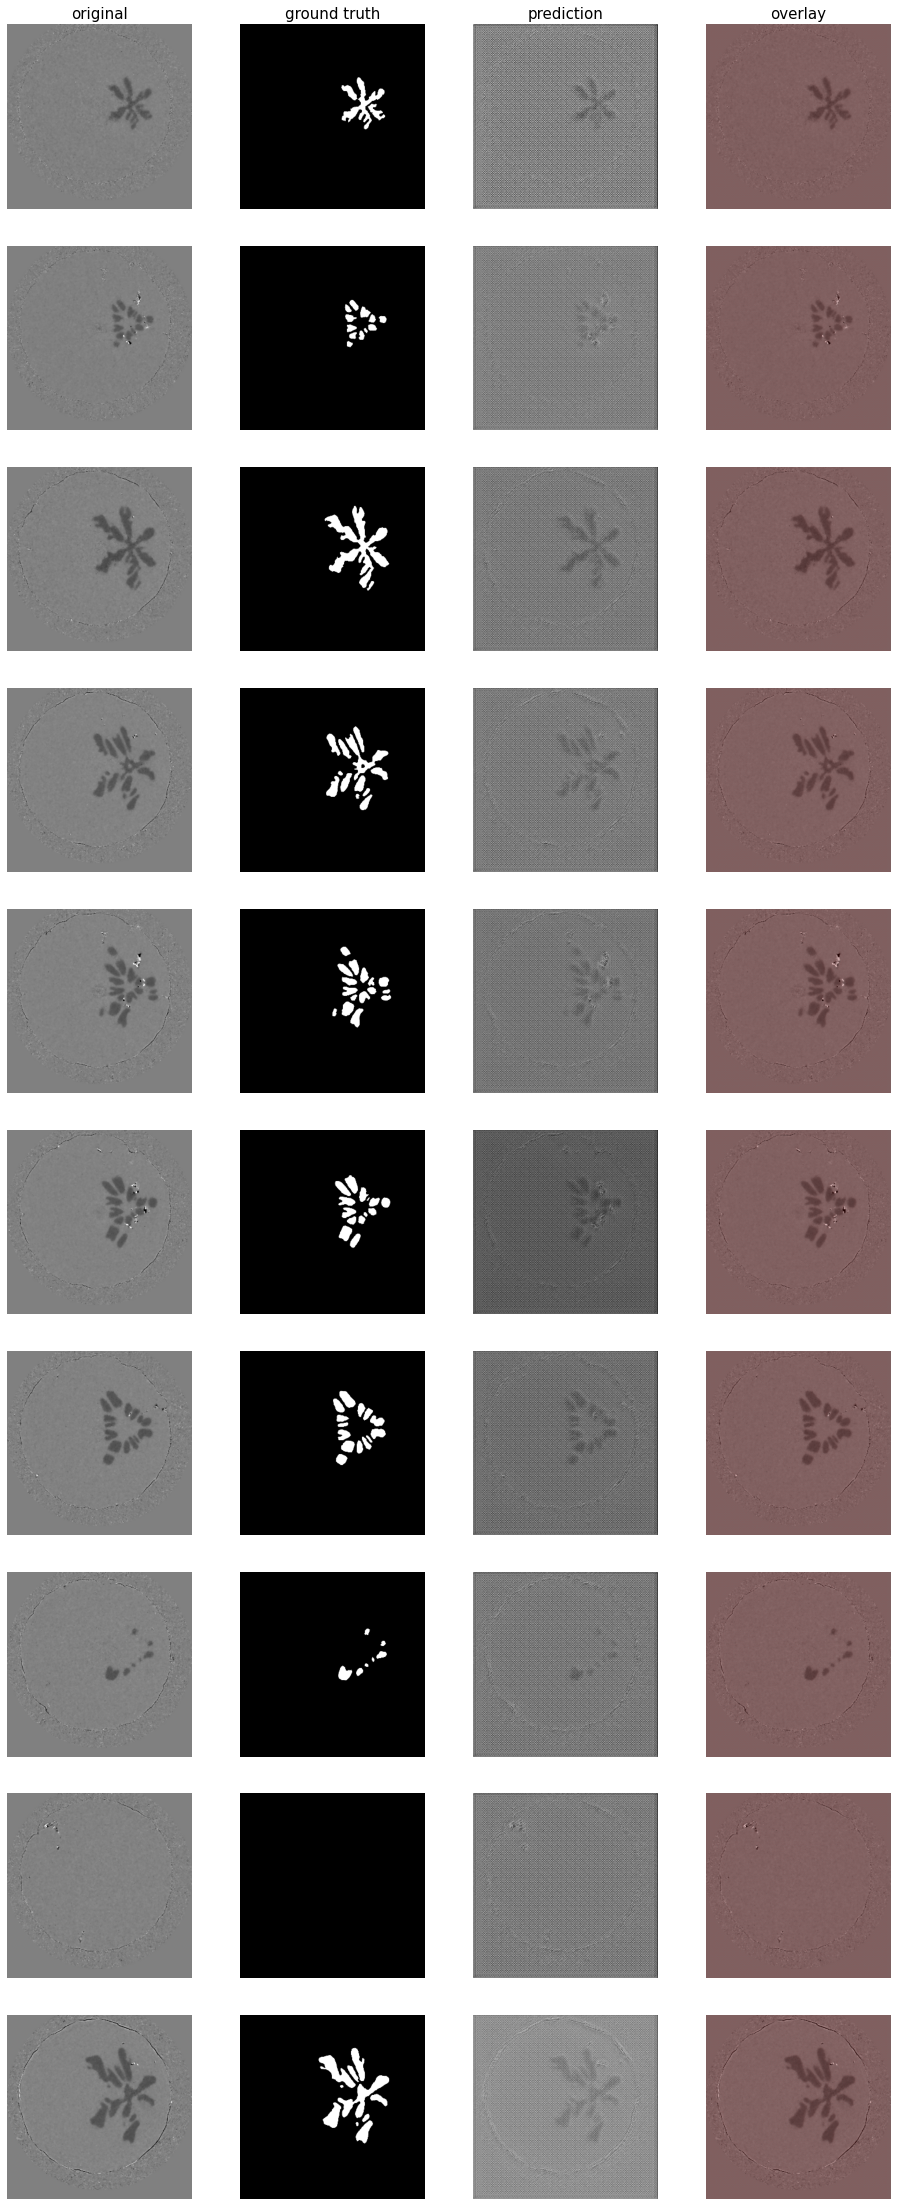

In [ ]:
plot_imgs(org_imgs=X_r, mask_imgs=y_c, pred_imgs=y_pred, nm_img_to_plot=10)

# Create Local Metadata
To publish your dataset to Foundry, you'll need to create a metadata file for your dataset so Foundry knows what your data is all about! Format your metadata using the code below, and then save it to `foundry_metadata.json`.

In [ ]:
metadata = {
    "dc": {
        'creators': [
            {'creatorName': 'Stan, Tiberiu',
             'familyName': 'Stan',
             'givenName': 'Tiberiu'},
            {'creatorName': 'Thompson, Zach',
             'familyName': 'Thompson',
             'givenName': 'Zach'},
            {'creatorName': 'Voorhees, Peter',
             'familyName': 'Voorhees',
             'givenName': 'Peter'}
        ],
        'dates': [{'date': '2020-06-04', 'dateType': 'Accepted'}],
        'identifier': {'identifier': '10.23677/xrmb-v1rz', 'identifierType': 'DOI'},
        'publicationYear': 2020,
        'publisher': 'Materials Data Facility',
        'resourceType': {'resourceType': 'Dataset', 'resourceTypeGeneral': 'Dataset'},
        'subjects': [
            {'subject': 'machine learning'},
            {'subject': 'segmentation'},
            {'subject': 'metals and alloys'},
            {'subject': 'X-ray tomography'},
            {'subject': 'foundry'}
        ],
        'titles': [{'title': 'Semantic Segmentation of Dendrites via Machine Learning'}]
    },
    "mdf": {"source_id":"_test_foundry_stan_dendrite_segmentation_v1.1"},
    "dataset": {
        "short_name": "stan-dendrite-segmentation",               
        "data_type": "hdf5",
        "keys":[
             {
                "key": ["train/input"],
                "type": "input",
                "units": "",
                "description": ""  
             },
             {
                 "key": ["train/output"],
                 "type": "output",
                 "units": "",
                 "description": ""  
             }
        ]
    }
    
}

In [ ]:
import json
with open('foundry_metadata.json', 'w') as f:
    json.dump(metadata, f)